In [375]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from fancyimpute import IterativeImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

National Life Expectancy Data

In [376]:
life_expectancy_data = pd.read_csv('U.S._State_Life_Expectancy_by_Sex__2020.csv')

Data from ROI

In [377]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

# Set seeds for reproducibility
np.random.seed(1)
random.seed(1)

# Constants
NUM_RECORDS = 100000
BIRTH_START_DATE = datetime(1910, 1, 1)
START_DATE = datetime(1980, 1, 1)
END_DATE = datetime(2023, 12, 31)
BIRTH_END_DATE = datetime(2000, 12, 31)
REGIONS = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
           'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
           'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
           'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
           'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
           'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
           'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
GENDERS = ['Male', 'Female', 'Total'] # Plan to use "Total" when gender is missing
PROSPECT_TYPES = ['Possible Planned Giving Prospect', 'Not Planned Giving Prospect', 'Planned Giving Prospect']

# Generate random dates within a range
def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# Generate normalized random amounts
def normalized_random_amount(min_amount, max_amount, size):
    mean = (max_amount + min_amount) / 2
    std_dev = (max_amount - min_amount) / 6  # 99.7% of values fall within +/- 3 standard deviations
    values = np.random.normal(mean, std_dev, size)
    values = np.clip(values, min_amount, max_amount)  # Ensure values are within range
    return values.round(2)

# Generate toy data
data = {
    'ID': range(1, NUM_RECORDS + 1),
    'region': np.random.choice(REGIONS, NUM_RECORDS),
    'gender': np.random.choice(GENDERS, NUM_RECORDS),
    'birth_date': [random_date(BIRTH_START_DATE, BIRTH_END_DATE) if random.random() > 0.2 else pd.NaT for _ in range(NUM_RECORDS)],
    'first_gift_date': [random_date(START_DATE, END_DATE) for _ in range(NUM_RECORDS)],
    'most_recent_gift_date': [random_date(START_DATE, END_DATE) for _ in range(NUM_RECORDS)],
    'death_date': [random_date(START_DATE, END_DATE) if random.random() > 0.9 else pd.NaT for _ in range(NUM_RECORDS)],
    'bequest_received': np.random.choice([0, 1], NUM_RECORDS, p=[0.7, 0.3]),
    'first_gift_amount': normalized_random_amount(1, 1000, NUM_RECORDS),
    'most_recent_gift_amount': normalized_random_amount(1, 10000, NUM_RECORDS),
    'highest_gift_date': [random_date(START_DATE, END_DATE) for _ in range(NUM_RECORDS)],
    'highest_gift_amount': normalized_random_amount(0, 10000, NUM_RECORDS),
    'capacity': normalized_random_amount(1, 100000, NUM_RECORDS),
    'prospect_type': np.random.choice(PROSPECT_TYPES, NUM_RECORDS)
}

df = pd.DataFrame(data)

# Ensure birth_date is before all other dates
df['birth_date'] = df.apply(lambda row: min(row['birth_date'], row['first_gift_date'], row['most_recent_gift_date'], row['highest_gift_date'], row['death_date']), axis=1)

# Ensure most recent gift date is after the first gift date
df['most_recent_gift_date'] = df.apply(lambda row: max(row['first_gift_date'], row['most_recent_gift_date']), axis=1)

# Ensure highest gift amount is larger than the most recent gift amount and the first gift amount
df['highest_gift_amount'] = df.apply(lambda row: max(row['highest_gift_amount'], row['most_recent_gift_amount'], row['first_gift_amount']), axis=1)

# Ensure first gift date is before death date
df['first_gift_date'] = df.apply(lambda row: min(row['first_gift_date'], row['death_date']) if not pd.isna(row['death_date']) else row['first_gift_date'], axis=1)

# Adjust death dates to ensure they are after all other dates
df['death_date'] = df.apply(lambda row: max(row['death_date'], row['first_gift_date'], row['most_recent_gift_date'], row['highest_gift_date']), axis=1)


# If dates match, make corresponding amounts match
df.loc[df['first_gift_date'] == df['highest_gift_date'], 'first_gift_amount'] = df['highest_gift_amount']
df.loc[df['most_recent_gift_date'] == df['highest_gift_date'], 'most_recent_gift_amount'] = df['highest_gift_amount']
df.loc[df['first_gift_date'] == df['most_recent_gift_date'], 'first_gift_amount'] = df['most_recent_gift_amount']

# Display the first few rows of the dataframe to verify
df.head(10)


,ID,region,gender,birth_date,first_gift_date,most_recent_gift_date,death_date,bequest_received,first_gift_amount,most_recent_gift_amount,highest_gift_date,highest_gift_amount,capacity,prospect_type
0,1,Pennsylvania,Male,NaT,2012-03-07,2019-03-09,NaT,0,362.01,4122.94,2002-09-25,4446.59,28264.36,Possible Planned Giving Prospect
1,2,Utah,Female,1921-04-28,2008-01-07,2008-01-07,NaT,1,2044.58,2044.58,2022-07-28,4003.33,60456.14,Possible Planned Giving Prospect
2,3,Illinois,Total,1990-10-19,2002-05-22,2022-03-11,NaT,1,362.99,3228.31,1990-10-19,4829.86,58871.09,Not Planned Giving Prospect
3,4,Florida,Male,1982-08-23,1994-01-27,2009-12-02,NaT,1,723.24,6063.81,1982-08-23,6063.81,41909.50,Not Planned Giving Prospect
4,5,Georgia,Female,1947-09-03,2023-03-18,2023-03-18,NaT,0,4824.28,4824.28,2015-03-30,4824.28,52318.93,Not Planned Giving Prospect
5,6,Idaho,Total,NaT,2022-04-23,2022-04-23,NaT,0,6923.42,6923.42,2009-05-27,6923.42,69962.82,Possible Planned Giving Prospect
6,7,Colorado,Total,NaT,1993-07-06,1993-07-06,NaT,0,5101.82,5101.82,1986-01-14,8104.17,28426.02,Planned Giving Prospect
7,8,Kansas,Female,1987-07-08,2018-12-29,2018-12-29,NaT,1,3732.12,3732.12,2019-10-16,5819.10,59273.68,Planned Giving Prospect
8,9,Alabama,Male,1910-05-19,2011-01-19,2011-01-19,NaT,1,3447.52,3447.52,2015-12-06,3447.52,87970.00,Planned Giving Prospect
9,10,Kentucky,Female,1957-10-15,2004-05-02,2004-05-02,NaT,0,4912.60,4912.60,2010-08-03,4912.60,63674.07,Possible Planned Giving Prospect


In [378]:
# Find proportion of missing values in each column
missing_proportions = df.isnull().mean()
missing_proportions

ID                         0.00000
region                     0.00000
gender                     0.00000
birth_date                 0.20122
first_gift_date            0.00000
most_recent_gift_date      0.00000
death_date                 0.89974
bequest_received           0.00000
first_gift_amount          0.00000
most_recent_gift_amount    0.00000
highest_gift_date          0.00000
highest_gift_amount        0.00000
capacity                   0.00000
prospect_type              0.00000
dtype: float64

Data Imputation

In [379]:
# Imputation with Multiple Imputation by Chained Equations
def impute_missing_data(data):
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)

In [380]:
# Copy the original birth_date column to birth_date_original
df['birth_date_original'] = df['birth_date']

# Prepare data for imputation (convert date to numerical format)
df['birth_date'] = pd.to_datetime(data['birth_date'], errors='coerce').astype(int) // 10**9

# Select relevant columns for imputation
columns_for_imputation = ['birth_date']
imputed_data = impute_missing_data(df[columns_for_imputation])

# Convert birth date back to datetime format
imputed_data['birth_date'] = pd.to_datetime(imputed_data['birth_date'])

# Incorporate the imputed data back into the original DataFrame
df['birth_date'] = imputed_data['birth_date']

# Where birth_date_original is not null, use the original birth_date value
df['birth_date'] = df['birth_date_original'].combine_first(df['birth_date']) 

df.head(10)

,ID,region,gender,birth_date,first_gift_date,most_recent_gift_date,death_date,bequest_received,first_gift_amount,most_recent_gift_amount,highest_gift_date,highest_gift_amount,capacity,prospect_type,birth_date_original
0,1,Pennsylvania,Male,1969-12-31 23:59:50.776627963,2012-03-07,2019-03-09,NaT,0,362.01,4122.94,2002-09-25,4446.59,28264.36,Possible Planned Giving Prospect,NaT
1,2,Utah,Female,1921-04-28 00:00:00.000000000,2008-01-07,2008-01-07,NaT,1,2044.58,2044.58,2022-07-28,4003.33,60456.14,Possible Planned Giving Prospect,1921-04-28
2,3,Illinois,Total,1990-10-19 00:00:00.000000000,2002-05-22,2022-03-11,NaT,1,362.99,3228.31,1990-10-19,4829.86,58871.09,Not Planned Giving Prospect,1990-10-19
3,4,Florida,Male,1982-08-23 00:00:00.000000000,1994-01-27,2009-12-02,NaT,1,723.24,6063.81,1982-08-23,6063.81,41909.50,Not Planned Giving Prospect,1982-08-23
4,5,Georgia,Female,1947-09-03 00:00:00.000000000,2023-03-18,2023-03-18,NaT,0,4824.28,4824.28,2015-03-30,4824.28,52318.93,Not Planned Giving Prospect,1947-09-03
5,6,Idaho,Total,1969-12-31 23:59:50.776627963,2022-04-23,2022-04-23,NaT,0,6923.42,6923.42,2009-05-27,6923.42,69962.82,Possible Planned Giving Prospect,NaT
6,7,Colorado,Total,1969-12-31 23:59:50.776627963,1993-07-06,1993-07-06,NaT,0,5101.82,5101.82,1986-01-14,8104.17,28426.02,Planned Giving Prospect,NaT
7,8,Kansas,Female,1987-07-08 00:00:00.000000000,2018-12-29,2018-12-29,NaT,1,3732.12,3732.12,2019-10-16,5819.10,59273.68,Planned Giving Prospect,1987-07-08
8,9,Alabama,Male,1910-05-19 00:00:00.000000000,2011-01-19,2011-01-19,NaT,1,3447.52,3447.52,2015-12-06,3447.52,87970.00,Planned Giving Prospect,1910-05-19
9,10,Kentucky,Female,1957-10-15 00:00:00.000000000,2004-05-02,2004-05-02,NaT,0,4912.60,4912.60,2010-08-03,4912.60,63674.07,Possible Planned Giving Prospect,1957-10-15


Identify Bequest Donors

In [381]:
# Identify bequest donors 
bequest_donors = df[df['bequest_received'] == 1]


Summarize Donors

In [382]:
# Group by region and bequest status
region_bequest_summary = df.groupby(['region', 'bequest_received']).agg(
    count=('ID', 'count'),
    avg_first_gift_amount=('first_gift_amount', 'mean'),
    avg_most_recent_gift_amount=('most_recent_gift_amount', 'mean'),
    avg_highest_gift_amount=('highest_gift_amount', 'mean'),
    avg_capacity=('capacity', 'mean')
).reset_index()

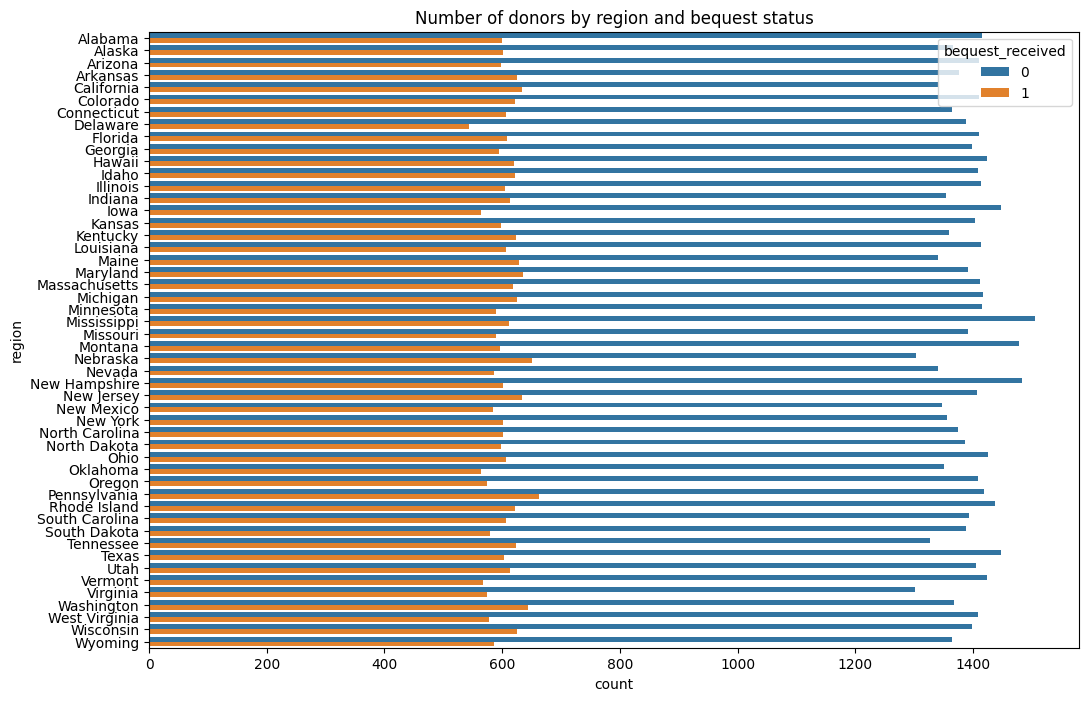

In [383]:
# Plot summary statistics
plt.figure(figsize=(12, 8))
sns.barplot(data=region_bequest_summary, x='count', y='region', hue='bequest_received')
plt.title('Number of donors by region and bequest status')
plt.show()

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#region_bequest_summary

Life Expectancy and Estimated Death Date

In [385]:
life_expectancy_data.columns

Index(['State', 'Sex', 'LE', 'SE', 'Quartile'], dtype='object')

In [386]:
# Function to match donors to life expectancy based on gender and location
def match_life_expectancy(row):
    gender = row['gender']
    location = row['region']  # Assuming 'region' column in your donor data
    le_data = life_expectancy_data[(life_expectancy_data['State'] == location) & 
                                   (life_expectancy_data['Sex'] == gender)]
    return le_data['LE'].values[0] if not le_data.empty else np.nan


In [387]:
df['life_expectancy'] = df.apply(match_life_expectancy, axis=1)


In [388]:
# Calculate expected death date based on life expectancy
df['expected_death_date'] = pd.to_datetime(df['birth_date']) + pd.to_timedelta(df['life_expectancy'] * 365, unit='D')


In [389]:
# Where death date is not NaT, overwrite expected death date with death date
df['expected_death_date'] = df.apply(lambda row: row['death_date'] if not pd.isna(row['death_date']) else row['expected_death_date'], axis=1)

In [390]:
df.head(10)

,ID,region,gender,birth_date,first_gift_date,most_recent_gift_date,death_date,bequest_received,first_gift_amount,most_recent_gift_amount,highest_gift_date,highest_gift_amount,capacity,prospect_type,birth_date_original,life_expectancy,expected_death_date
0,1,Pennsylvania,Male,1969-12-31 23:59:50.776627963,2012-03-07,2019-03-09,NaT,0,362.01,4122.94,2002-09-25,4446.59,28264.36,Possible Planned Giving Prospect,NaT,74.0,2043-12-13 23:59:50.776627963
1,2,Utah,Female,1921-04-28 00:00:00.000000000,2008-01-07,2008-01-07,NaT,1,2044.58,2044.58,2022-07-28,4003.33,60456.14,Possible Planned Giving Prospect,1921-04-28,80.6,2001-11-12 23:59:59.999999688
2,3,Illinois,Total,1990-10-19 00:00:00.000000000,2002-05-22,2022-03-11,NaT,1,362.99,3228.31,1990-10-19,4829.86,58871.09,Not Planned Giving Prospect,1990-10-19,76.8,2067-07-19 00:00:00.000000000
3,4,Florida,Male,1982-08-23 00:00:00.000000000,1994-01-27,2009-12-02,NaT,1,723.24,6063.81,1982-08-23,6063.81,41909.50,Not Planned Giving Prospect,1982-08-23,74.6,2057-03-10 23:59:59.999999688
4,5,Georgia,Female,1947-09-03 00:00:00.000000000,2023-03-18,2023-03-18,NaT,0,4824.28,4824.28,2015-03-30,4824.28,52318.93,Not Planned Giving Prospect,1947-09-03,78.3,2025-12-01 12:00:00.000000000
5,6,Idaho,Total,1969-12-31 23:59:50.776627963,2022-04-23,2022-04-23,NaT,0,6923.42,6923.42,2009-05-27,6923.42,69962.82,Possible Planned Giving Prospect,NaT,78.4,2048-05-06 23:59:50.776628274
6,7,Colorado,Total,1969-12-31 23:59:50.776627963,1993-07-06,1993-07-06,NaT,0,5101.82,5101.82,1986-01-14,8104.17,28426.02,Planned Giving Prospect,NaT,78.3,2048-03-31 11:59:50.776627963
7,8,Kansas,Female,1987-07-08 00:00:00.000000000,2018-12-29,2018-12-29,NaT,1,3732.12,3732.12,2019-10-16,5819.10,59273.68,Planned Giving Prospect,1987-07-08,79.2,2066-08-30 00:00:00.000000000
8,9,Alabama,Male,1910-05-19 00:00:00.000000000,2011-01-19,2011-01-19,NaT,1,3447.52,3447.52,2015-12-06,3447.52,87970.00,Planned Giving Prospect,1910-05-19,70.1,1980-06-06 11:59:59.999999688
9,10,Kentucky,Female,1957-10-15 00:00:00.000000000,2004-05-02,2004-05-02,NaT,0,4912.60,4912.60,2010-08-03,4912.60,63674.07,Possible Planned Giving Prospect,1957-10-15,76.5,2034-03-27 12:00:00.000000000


In [391]:
# Calculate time in days from first gift to expected death
df['time_to_expected_death'] = (df['expected_death_date'] - df['first_gift_date']).dt.days

# event_observed is True if death_date is not NaT
df['event_observed'] = ~df['death_date'].isnull()

In [392]:
# Remove records where time_to_expected_death is negative
df = df[df['time_to_expected_death'] >= 0]

In [393]:
df.head()

,ID,region,gender,birth_date,first_gift_date,most_recent_gift_date,death_date,bequest_received,first_gift_amount,most_recent_gift_amount,highest_gift_date,highest_gift_amount,capacity,prospect_type,birth_date_original,life_expectancy,expected_death_date,time_to_expected_death,event_observed
0,1,Pennsylvania,Male,1969-12-31 23:59:50.776627963,2012-03-07,2019-03-09,NaT,0,362.01,4122.94,2002-09-25,4446.59,28264.36,Possible Planned Giving Prospect,NaT,74.0,2043-12-13 23:59:50.776627963,11603,False
2,3,Illinois,Total,1990-10-19 00:00:00.000000000,2002-05-22,2022-03-11,NaT,1,362.99,3228.31,1990-10-19,4829.86,58871.09,Not Planned Giving Prospect,1990-10-19,76.8,2067-07-19 00:00:00.000000000,23799,False
3,4,Florida,Male,1982-08-23 00:00:00.000000000,1994-01-27,2009-12-02,NaT,1,723.24,6063.81,1982-08-23,6063.81,41909.50,Not Planned Giving Prospect,1982-08-23,74.6,2057-03-10 23:59:59.999999688,23053,False
4,5,Georgia,Female,1947-09-03 00:00:00.000000000,2023-03-18,2023-03-18,NaT,0,4824.28,4824.28,2015-03-30,4824.28,52318.93,Not Planned Giving Prospect,1947-09-03,78.3,2025-12-01 12:00:00.000000000,989,False
5,6,Idaho,Total,1969-12-31 23:59:50.776627963,2022-04-23,2022-04-23,NaT,0,6923.42,6923.42,2009-05-27,6923.42,69962.82,Possible Planned Giving Prospect,NaT,78.4,2048-05-06 23:59:50.776628274,9510,False


Survival Analysis - Kaplan-Meier

In [394]:
# Kaplan-Meier Survival Analysis - overall survival function
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(df['time_to_expected_death'], event_observed=df['event_observed'], label='Survival Function')

<lifelines.KaplanMeierFitter:"Survival Function", fitted with 87339 total observations, 77313 right-censored observations>

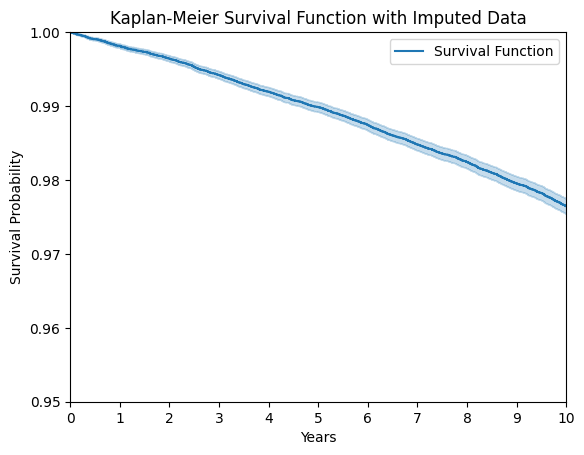

In [395]:
# Plot the survival function
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Function with Imputed Data')
plt.xlabel('Years')
plt.ylabel('Survival Probability')
# Max x-axis limit to 10 years
plt.xlim(0, 365*10)
# Y-axis from .9 to 1
plt.ylim(0.95, 1)
# Show tick marks at 1 year intervals
plt.xticks(np.arange(0, 365*11, 365))
# change labels to years
plt.xticks(np.arange(0, 365*11, 365), np.arange(0, 11, 1))
plt.show()

In [396]:
# Predict survival probabilities for the next 5 years
time_points = np.arange(0, 5*365, 365)  # yearly intervals up to 5 years
survival_probabilities = kmf.predict(time_points)


In [397]:
print('Overall Survival Probabilities for the Next 5 Years:')
survival_probabilities

Overall Survival Probabilities for the Next 5 Years:


0       1.000000
365     0.998138
730     0.996436
1095    0.994206
1460    0.991946
Name: Survival Function, dtype: float64

In [398]:
# Map region to "chapter_code" based on a dictionary of chapter codes
chapter_codes = {
    'Alaska': 'AKRO',
    'Alabama': 'SERO',
    'Arkansas': 'SERO',
    'Arizona': 'SWRO',
    'California': 'PARO',
    'Colorado': 'SWRO',
    'Connecticut': 'NERO',
    'Delaware': 'MARO',
    'Florida': 'SCRO',
    'Georgia': 'SERO',
    'Hawaii': 'PARO',
    'Iowa': 'MWRO',
    'Idaho': 'NRRO',
    'Illinois': 'MWRO',
    'Indiana': 'MWRO',
    'Kansas': 'MWRO',
    'Kentucky': 'SERO',
    'Louisiana': 'SCRO',
    'Massachusetts': 'NERO',
    'Maryland': 'MARO',
    'Maine': 'NERO',
    'Michigan': 'MWRO',
    'Minnesota': 'MWRO',
    'Missouri': 'MWRO',
    'Mississippi': 'SERO',
    'Montana': 'NRRO',
    'North Carolina': 'SERO',
    'North Dakota': 'NRRO',
    'Nebraska': 'MWRO',
    'New Hampshire': 'NERO',
    'New Jersey': 'NERO',
    'New Mexico': 'SWRO',
    'Nevada': 'PARO',
    'New York': 'NERO',
    'Ohio': 'MWRO',
    'Oklahoma': 'TXRO',
    'Oregon': 'NWRO',
    'Pennsylvania': 'MARO',
    'Rhode Island': 'NERO',
    'South Carolina': 'SERO',
    'South Dakota': 'MWRO',
    'Tennessee': 'SERO',
    'Texas': 'TXRO',
    'Utah': 'SWRO',
    'Virginia': 'MARO',
    'Vermont': 'NERO',
    'Washington': 'NWRO',
    'Wisconsin': 'MWRO',
    'West Virginia': 'MARO',
    'Wyoming': 'NRRO'
}

In [399]:
# Add new column 'chapter_code' to the df based on the 'region'
df['chapter_code'] = df['region'].map(chapter_codes)

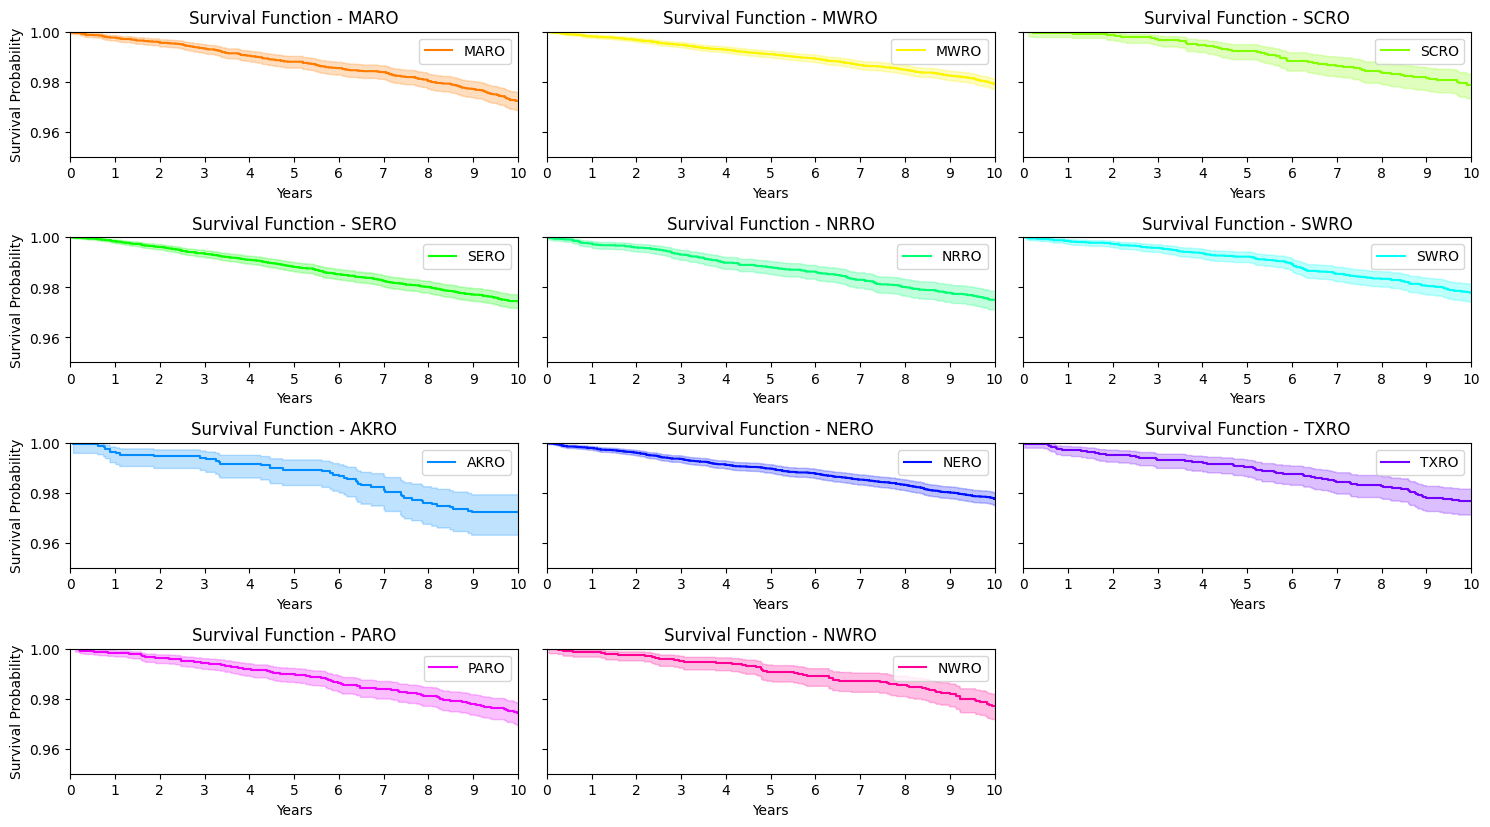

In [400]:
# Kaplan-Meier Survival Analysis - region-wise survival function
regions = df['chapter_code'].unique()
num_regions = len(regions)
cols = 3
rows = (num_regions // cols) + (num_regions % cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=False, sharey=True)
axes = axes.flatten()

kmf = KaplanMeierFitter()
colors = sns.color_palette("hsv", num_regions)  # Using seaborn to generate a color palette

for i, (region, color) in enumerate(zip(regions, colors)):
    ax = axes[i]
    region_data = df[df['chapter_code'] == region]
    kmf.fit(region_data['time_to_expected_death'], event_observed=region_data['event_observed'], label=region)
    kmf.plot_survival_function(ax=ax, color=color)
    ax.set_title(f'Survival Function - {region}')
    ax.set_xlim(0, 365*10)
    ax.set_ylim(0.95, 1)
    
    # Set x-ticks to show years
    years = np.arange(0, 11, 1)
    ax.set_xticks(years * 365)
    ax.set_xticklabels(years)
    
    ax.set_xlabel('Years')
    ax.set_ylabel('Survival Probability')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Validation - imputation cross-validation

In [401]:
def cross_validate_imputation(df, columns_for_imputation, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    errors = []

    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        
        # Fit the imputer on the training data
        imputer = IterativeImputer(max_iter=10, random_state=0)
        imputer.fit(train_df[columns_for_imputation])

        # Transform both training and test data
        imputed_train = imputer.transform(train_df[columns_for_imputation])
        imputed_test = imputer.transform(test_df[columns_for_imputation])

        # Calculate MAE on the test data
        error = mean_absolute_error(test_df[columns_for_imputation], imputed_test)
        errors.append(error)
    
    return errors

In [402]:
columns_for_imputation = ['birth_date_original']

In [403]:
df[['birth_date_original']].head()

,birth_date_original
0,NaT
2,1990-10-19
3,1982-08-23
4,1947-09-03
5,NaT


In [404]:
# Convert 'birth_date' column to numerical format
df['birth_date_original'] = pd.to_datetime(df['birth_date_original'], errors='coerce').astype(int) // 10**9

# Perform cross-validation on imputation
imputation_errors = cross_validate_imputation(df, columns_for_imputation)
print(f"Imputation MAE: {np.mean(imputation_errors):.4f}")

Imputation MAE: 0.0000


Validation - C-Index

In [405]:
def validate_survival_analysis(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    c_indices = []

    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]

        kmf = KaplanMeierFitter()
        kmf.fit(train_df['time_to_expected_death'], event_observed=train_df['event_observed'])
        
        c_index = concordance_index(test_df['time_to_expected_death'], -kmf.predict(test_df['time_to_expected_death']), test_df['event_observed'])
        c_indices.append(c_index)
    
    return c_indices

c_indices = validate_survival_analysis(df)
print(f"C-Index: {np.mean(c_indices):.4f}")


C-Index: 0.9999


In [406]:
#TODO: focus on bequest timelines